In [1]:
import pandas as pd
import datetime as dt
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
plt.style.use('fivethirtyeight')

In [2]:
file_path = r'data\elo_data_set.csv'
elo_df = pd.read_csv(file_path, parse_dates=[0])
teams = []
for i in elo_df['team'].unique(): #constructs list of team names
    teams.append(i)
elo_df.head()

,datetime,team,season,opp,day_week,week,W/L,ot,record,home/away,...,defense_expected_points,sp_expected_points,team_elo_before_all,team_elo_after_all,opp_elo_before_all,opp_elo_after_all,team_elo_before_season,team_elo_after_season,opp_elo_before_season,opp_elo_after_season
0,2002-09-05 20:38:00,NYG,2002,SFO,Thu,1,0.0,0.0,0-1,HOME,...,-0.79,3.46,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
1,2002-09-08 13:04:00,CAR,2002,BAL,Sun,1,1.0,0.0,1-0,HOME,...,6.68,4.20,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
2,2002-09-08 13:04:00,CHI,2002,MIN,Sun,1,1.0,0.0,1-0,HOME,...,-1.20,1.01,1500.0,1515.0,1500.0,1485.0,1500.0,1520.0,1500.0,1480.0
3,2002-09-08 13:04:00,CLE,2002,KAN,Sun,1,0.0,0.0,0-1,HOME,...,-17.94,1.15,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0
4,2002-09-08 13:04:00,BUF,2002,NYJ,Sun,1,0.0,1.0,0-1,HOME,...,0.59,-7.81,1500.0,1485.0,1500.0,1515.0,1500.0,1480.0,1500.0,1520.0


In [3]:
# separates out played games, and the upcoming week.
#season_df = elo_df[elo_df['season']==dt.datetime.today()]
season_df = elo_df[elo_df['season']==dt.datetime.today().year]

history_df = elo_df[elo_df['datetime'] < dt.datetime.today()]

future_df = season_df[season_df['datetime'] >= dt.datetime.today()]


upcoming_week = history_df['week'].iloc[-1] + 1
future_df = future_df[future_df['week'] == upcoming_week]
future_df = future_df[['datetime', 'team', 'opp', 'team_score', 'opp_score', 'team_elo_before_all', 'opp_elo_before_all', 'team_elo_before_season', 'opp_elo_before_season', 'W/L']]
print(f'Week to predict : {upcoming_week}')

Week to predict : 17


In [4]:
# Generates a dictionary of dataframes for points gained/allowed per team. This allows convenient generation of the distributions fed into the game 
team_data_dict_all = {}
team_data_dict_season = {}
for i in range(len(teams)):
    team = teams[i]
    team_data_all = pd.DataFrame()
    team_data_season = pd.DataFrame()
    
    team_off_all = []
    team_def_all = []
    team_elo_all = []
    
    team_off_season = []
    team_def_season = []
    team_elo_season = []
    
    team_df_all = history_df[(history_df['team'] == f'{team}') | (history_df['opp'] == f'{team}')]
    team_df_season = season_df[(season_df['team'] == f'{team}') | (season_df['opp'] == f'{team}')]
    team_df_all.reset_index(inplace=True)
    team_df_all.drop('index', axis=1, inplace=True)
    
    team_df_season.reset_index(inplace=True)
    team_df_season.drop('index', axis=1, inplace=True)
    
    for x in range(len(team_df_all)):
        if team_df_all['team'].iloc[x] == f'{team}':
            team_off_all.append(team_df_all['team_score'][x])
            team_def_all.append(team_df_all['opp_score'][x])
            team_elo_all.append(team_df_all['team_elo_before_all'][x])
        else:
            team_off_all.append(team_df_all['opp_score'][x])
            team_def_all.append(team_df_all['team_score'][x])
            team_elo_all.append(team_df_all['opp_elo_before_all'][x])
            
    for y in range(len(team_df_season)):
        if team_df_all['team'].iloc[y] == f'{team}':
            team_off_season.append(team_df_season['team_score'][y])
            team_def_season.append(team_df_season['opp_score'][y])
            team_elo_season.append(team_df_season['team_elo_before_all'][y])
        else:
            team_off_season.append(team_df_season['opp_score'][y])
            team_def_season.append(team_df_season['team_score'][y])
            team_elo_season.append(team_df_season['opp_elo_before_all'][y])
    
    team_data_all['team_off'] = team_off_all
    team_data_all['team_def'] = team_def_all
    team_data_all['elo'] = team_elo_all
    team_data_dict_all[team] = team_data_all
    
    team_data_season['team_off'] = team_off_season
    team_data_season['team_def'] = team_def_season
    team_data_season['elo'] = team_elo_season
    team_data_season.dropna(inplace=True)
    team_data_dict_season[team] = team_data_season
      
   
print(len(team_data_dict_all.keys()), ' ' , len(team_data_dict_season.keys()))

C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib

32   32


C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\fitzp\anaconda3\lib

In [5]:
team_data_dict_all['NYJ']

,team_off,team_def,elo
0,37.0,31.0,1500.000000
1,7.0,44.0,1515.000000
2,3.0,30.0,1500.000000
3,3.0,28.0,1486.291995
4,25.0,29.0,1471.939195
...,...,...,...
309,3.0,20.0,1308.967905
310,28.0,31.0,1300.386795
311,3.0,40.0,1292.061900
312,23.0,20.0,1287.851914


In [6]:
sampled_data = {}

for team in team_data_dict_all.keys():
    team_off = []
    team_def = []
    team_df = pd.DataFrame()
    
    for i in range(100):
        team_off.append(team_data_dict_all[team]['team_off'].sample(50, replace=True).mean())
        team_def.append(team_data_dict_all[team]['team_def'].sample(50, replace=True).mean())
    
    team_df['off'] = team_off
    team_df['def'] = team_def
    
    sampled_data[team] = team_df

sampled_data['CHI']

,off,def
0,19.84,22.22
1,21.58,21.26
2,20.90,20.72
3,23.98,21.96
4,22.08,23.10
...,...,...
95,20.12,22.12
96,20.56,21.30
97,20.74,21.78
98,21.04,20.70


In [7]:
# Games to be predicted
future_df.reset_index(inplace=True)
future_df.drop('index', axis=1, inplace=True)
future_df['team_elo_prediction_all%'] = np.nan
future_df['opp_elo_prediction_all%'] = np.nan
future_df['team_gauss_prediction_all%'] = np.nan
future_df['opp_gauss_prediction_all%'] = np.nan
future_df['tie_gauss_prediction_all%'] = np.nan

future_df['team_elo_prediction_season%'] = np.nan
future_df['opp_elo_prediction_season%'] = np.nan
future_df['team_gauss_prediction_season%'] = np.nan
future_df['opp_gauss_prediction_season%'] = np.nan
future_df['tie_gauss_prediction_season%'] = np.nan

future_df['team_gauss_sample%'] = np.nan
future_df['opp_gauss_sample%'] = np.nan
future_df['tie_gauss_sample%'] = np.nan



future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,...,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%,team_gauss_sample%,opp_gauss_sample%,tie_gauss_sample%
0,2021-01-03 13:00:00,CLE,PIT,NaN,NaN,1450.646863,1614.369345,1514.017872,1421.824046,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-03 13:00:00,DET,MIN,NaN,NaN,1371.731841,1515.628272,1356.191740,1322.444688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-03 13:00:00,NWE,NYJ,NaN,NaN,1585.944963,1335.241163,1447.087860,1617.081993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-03 13:00:00,CIN,BAL,NaN,NaN,1325.562181,1638.563673,1601.120968,1433.047390,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-03 13:00:00,BUF,MIA,NaN,NaN,1601.736172,1511.844808,1444.570269,1477.316026,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-01-03 13:00:00,TAM,ATL,NaN,NaN,1526.722906,1451.298621,1469.834082,1420.798728,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-01-03 13:00:00,NYG,DAL,NaN,NaN,1363.070110,1491.392083,1331.075684,1547.055527,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-01-03 16:25:00,CAR,NOR,NaN,NaN,1402.678259,1677.291385,1339.868535,1529.978896,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-01-03 16:25:00,LAR,ARI,NaN,NaN,1573.138820,1453.090566,1529.439427,1417.534787,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-01-03 16:25:00,SFO,SEA,NaN,NaN,1511.719814,1631.792680,1428.513782,1417.625834,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# functions to simulate games

def elo_expected(teamA, teamB, dictionary):
    rating_A = dictionary[teamA]['elo'].iloc[-1]
    rating_B = dictionary[teamB]['elo'].iloc[-1]
    expected_A = 1 / (1 + 10 ** ((rating_B - rating_A) / 400 ))
    expected_B = 1 / (1 + 10 ** ((rating_A - rating_B) / 400 ))
    return [expected_A, expected_B]

def elo_game_sim(teamA, teamB, dictionary):
    win_values = elo_expected(teamA, teamB, dictionary)
    win_gen = rnd.random()
    if win_values[0] > win_values[1]:
        if win_gen < win_values[0]:
            return [1, 0]
        else:
            return [0, 1]
    if win_values[0] < win_values[1]:
        if win_gen < win_values[1]:
            return [0, 1]
        else:
            return[1, 0]

def elo_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    for i in range(runs):
        game = elo_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game[0] == 1:
            teamA_wins += 1
        else:
            teamB_wins += 1
    return [teamA_wins, teamB_wins]


def gauss_game_sim(teamA, teamB, dictionary):
    team_A_score = (rnd.gauss(dictionary[teamA]['team_off'].mean(), dictionary[teamA]['team_off'].std()) + rnd.gauss(dictionary[teamB]['team_def'].mean(), dictionary[teamB]['team_def'].std()))/2
    team_B_score = (rnd.gauss(dictionary[teamB]['team_off'].mean(), dictionary[teamB]['team_off'].std()) + rnd.gauss(dictionary[teamA]['team_def'].mean(), dictionary[teamA]['team_def'].std()))/2
    if int(round(team_A_score)) > int(round(team_B_score)):
        return 1
    elif int(round(team_A_score)) < int(round(team_B_score)):
        return -1
    else: 
        return 0

def gauss_series_sim(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    ties = 0
    for i in range(runs):
        game = gauss_game_sim(teamA, teamB, dictionary)
        games.append(game)
        if game == 1:
            teamA_wins += 1
        elif game== -1:
            teamB_wins += 1
        else:
            gauss_game_sim(teamA, teamB, dictionary)
    return [teamA_wins, teamB_wins, ties]

def gauss_game_sim_sampled(teamA, teamB, dictionary):
    team_a_data = dictionary[teamA]
    team_b_data = dictionary[teamB]
    
    
    team_A_score = ((rnd.gauss(stat.mean(team_a_data['off']), team_a_data['off'].std())) + (rnd.gauss(stat.mean(team_b_data['def']), team_b_data['def'].std())))/2
    team_B_score = ((rnd.gauss(stat.mean(team_b_data['off']), team_b_data['off'].std())) + (rnd.gauss(stat.mean(team_a_data['def']), team_a_data['def'].std())))/2
    
    if int(round(team_A_score)) > int(round(team_B_score)):
        return 1
    elif int(round(team_A_score)) < int(round(team_B_score)):
        return -1
    else: 
        return 0

def gauss_series_sim_sampled(teamA, teamB, runs, dictionary):
    games = []
    teamA_wins = 0
    teamB_wins = 0
    ties = 0
    for i in range(runs):
        game = gauss_game_sim_sampled(teamA, teamB, dictionary)
        games.append(game)
        if game == 1:
            teamA_wins += 1
        elif game== -1:
            teamB_wins += 1
        else:
            gauss_game_sim_sampled(teamA, teamB, dictionary)
    return [teamA_wins, teamB_wins, ties]

In [9]:
%time
gauss_series_sim_sampled('GNB', 'CHI', 1000, sampled_data)

Wall time: 0 ns


[910, 19, 0]

In [10]:
%%time
# simulations and future_df update
num_sims = 50000
for i in range(len(future_df)):
    teamA = future_df['team'].iloc[i]
    teamB = future_df['opp'].iloc[i]
    
    elo_result = elo_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    elo_result_A = elo_result[0] / (elo_result[0] + elo_result[1])
    elo_result_B = elo_result[1] / (elo_result[0] + elo_result[1])
    future_df['team_elo_prediction_all%'].iloc[i] = elo_result_A
    future_df['opp_elo_prediction_all%'].iloc[i] = elo_result_B
    
    gauss_result = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_all)
    gauss_result_A = gauss_result[0] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_B = gauss_result[1] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    gauss_result_tie = gauss_result[2] / (gauss_result[0] + gauss_result[1] + gauss_result[2])
    future_df['team_gauss_prediction_all%'].iloc[i] = gauss_result_A
    future_df['opp_gauss_prediction_all%'].iloc[i] = gauss_result_B
    future_df['tie_gauss_prediction_all%'].iloc[i] = gauss_result_tie
    
    elo_result_season = elo_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    elo_result_A_season = elo_result_season[0] / (elo_result_season[0] + elo_result_season[1])
    elo_result_B_season = elo_result_season[1] / (elo_result_season[0] + elo_result_season[1])
    future_df['team_elo_prediction_season%'].iloc[i] = elo_result_A_season
    future_df['opp_elo_prediction_season%'].iloc[i] = elo_result_B_season
    
    gauss_result_season = gauss_series_sim(teamA, teamB, num_sims, team_data_dict_season)
    gauss_result_A_season = gauss_result_season[0] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_B_season = gauss_result_season[1] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    gauss_result_tie_season = gauss_result_season[2] / (gauss_result_season[0] + gauss_result_season[1] + gauss_result_season[2])
    future_df['team_gauss_prediction_season%'].iloc[i] = gauss_result_A_season
    future_df['opp_gauss_prediction_season%'].iloc[i] = gauss_result_B_season
    future_df['tie_gauss_prediction_season%'].iloc[i] = gauss_result_tie_season
    
    gauss_sample_result = gauss_series_sim_sampled(teamA, teamB, num_sims, sampled_data)
    gauss_sample_A = gauss_sample_result[0] / (gauss_sample_result[0] + gauss_sample_result[1] + gauss_sample_result[2])
    gauss_sample_B = gauss_sample_result[1] / (gauss_sample_result[0] + gauss_sample_result[1] + gauss_sample_result[2])
    gauss_result_tie_sample = gauss_sample_result[2] / (gauss_sample_result[0] + gauss_sample_result[1] + gauss_sample_result[2])
    future_df['team_gauss_sample%'].iloc[i] = gauss_sample_A
    future_df['opp_gauss_sample%'].iloc[i] = gauss_sample_B
    future_df['tie_gauss_sample%'].iloc[i] = gauss_result_tie_sample
    
    print('-----------------------------------------------------------------------------')
    print(f'TEAMS : {teamA} | {teamB}')
    print(f'HISTORICAL PREDICTION: elo_result: {elo_result} | gaussian_result: {gauss_result}')
    print(f'SEASON PREDICTION: elo_result: {elo_result_season} | gaussian_result: {gauss_result_season}')
    print(f'Sampled Prediction: {gauss_sample_result}')

C:\Users\fitzp\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-----------------------------------------------------------------------------
TEAMS : CLE | PIT
HISTORICAL PREDICTION: elo_result: [16111, 33889] | gaussian_result: [14792, 33399, 0]
SEASON PREDICTION: elo_result: [19113, 30887] | gaussian_result: [19855, 28418, 0]
Sampled Prediction: [6, 49933, 0]
-----------------------------------------------------------------------------
TEAMS : DET | MIN
HISTORICAL PREDICTION: elo_result: [15325, 34675] | gaussian_result: [19033, 28964, 0]
SEASON PREDICTION: elo_result: [14709, 35291] | gaussian_result: [30193, 17775, 0]
Sampled Prediction: [709, 46388, 0]
-----------------------------------------------------------------------------
TEAMS : NWE | NYJ
HISTORICAL PREDICTION: elo_result: [41245, 8755] | gaussian_result: [34498, 13896, 0]
SEASON PREDICTION: elo_result: [34242, 15758] | gaussian_result: [30666, 17589, 0]
Sampled Prediction: [49985, 1, 0]
-----------------------------------------------------------------------------
TEAMS : CIN | BAL
HIS

In [11]:
future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,...,opp_gauss_prediction_all%,tie_gauss_prediction_all%,team_elo_prediction_season%,opp_elo_prediction_season%,team_gauss_prediction_season%,opp_gauss_prediction_season%,tie_gauss_prediction_season%,team_gauss_sample%,opp_gauss_sample%,tie_gauss_sample%
0,2021-01-03 13:00:00,CLE,PIT,NaN,NaN,1450.646863,1614.369345,1514.017872,1421.824046,NaN,...,0.693055,0.0,0.38226,0.61774,0.411307,0.588693,0.0,0.000120,0.999880,0.0
1,2021-01-03 13:00:00,DET,MIN,NaN,NaN,1371.731841,1515.628272,1356.191740,1322.444688,NaN,...,0.603454,0.0,0.29418,0.70582,0.629440,0.370560,0.0,0.015054,0.984946,0.0
2,2021-01-03 13:00:00,NWE,NYJ,NaN,NaN,1585.944963,1335.241163,1447.087860,1617.081993,NaN,...,0.287143,0.0,0.68484,0.31516,0.635499,0.364501,0.0,0.999980,0.000020,0.0
3,2021-01-03 13:00:00,CIN,BAL,NaN,NaN,1325.562181,1638.563673,1601.120968,1433.047390,NaN,...,0.610948,0.0,0.28074,0.71926,0.603204,0.396796,0.0,0.016742,0.983258,0.0
4,2021-01-03 13:00:00,BUF,MIA,NaN,NaN,1601.736172,1511.844808,1444.570269,1477.316026,NaN,...,0.496205,0.0,0.44360,0.55640,0.577589,0.422411,0.0,0.569745,0.430255,0.0
5,2021-01-03 13:00:00,TAM,ATL,NaN,NaN,1526.722906,1451.298621,1469.834082,1420.798728,NaN,...,0.544240,0.0,0.09706,0.90294,0.454742,0.545258,0.0,0.235374,0.764626,0.0
6,2021-01-03 13:00:00,NYG,DAL,NaN,NaN,1363.070110,1491.392083,1331.075684,1547.055527,NaN,...,0.535683,0.0,0.34940,0.65060,0.484485,0.515515,0.0,0.226073,0.773927,0.0
7,2021-01-03 16:25:00,CAR,NOR,NaN,NaN,1402.678259,1677.291385,1339.868535,1529.978896,NaN,...,0.563409,0.0,0.32466,0.67534,0.692106,0.307894,0.0,0.091664,0.908336,0.0
8,2021-01-03 16:25:00,LAR,ARI,NaN,NaN,1573.138820,1453.090566,1529.439427,1417.534787,NaN,...,0.510836,0.0,0.66802,0.33198,0.566759,0.433241,0.0,0.431144,0.568856,0.0
9,2021-01-03 16:25:00,SFO,SEA,NaN,NaN,1511.719814,1631.792680,1428.513782,1417.625834,NaN,...,0.592136,0.0,0.33436,0.66564,0.309457,0.690543,0.0,0.033364,0.966636,0.0


In [12]:
predictions = []
predicted_teams = []
home_predict = []
opp_predict =[]
margin = []

# multipliers
e = 0.4
g = 0.2
s = 0.4

for i in range(len(future_df)):
    home = (e * (future_df["team_elo_prediction_all%"][i])) + (g * (future_df["team_gauss_prediction_all%"][i])) + (e *(future_df["team_elo_prediction_season%"][i])) +  (s * (future_df['team_gauss_sample%'][i]))
            
    opp = (e * (future_df["opp_elo_prediction_all%"][i])) + (g * (future_df["opp_gauss_prediction_all%"][i])) + (e * (future_df["opp_elo_prediction_season%"][i])) + (s * (future_df['opp_gauss_sample%'][i]))
    
    if home > opp:
        predictions.append(0)
        predicted_teams.append(future_df['team'].iloc[i])
        home_predict.append(home)
        opp_predict.append(opp)
        margin.append(home - opp)
    else:
        predictions.append(1)
        predicted_teams.append(future_df['opp'].iloc[i])
        home_predict.append(home)
        opp_predict.append(opp)
        margin.append(opp - home)

future_df['home_sum_predict'] = home_predict
future_df['opp_sum_predict'] = opp_predict
future_df['margin'] = margin
future_df['predicted_team'] = predicted_teams        
future_df['predicted_outcome'] = predictions


In [13]:
future_df

,datetime,team,opp,team_score,opp_score,team_elo_before_all,opp_elo_before_all,team_elo_before_season,opp_elo_before_season,W/L,...,opp_gauss_prediction_season%,tie_gauss_prediction_season%,team_gauss_sample%,opp_gauss_sample%,tie_gauss_sample%,home_sum_predict,opp_sum_predict,margin,predicted_team,predicted_outcome
0,2021-01-03 13:00:00,CLE,PIT,NaN,NaN,1450.646863,1614.369345,1514.017872,1421.824046,NaN,...,0.588693,0.0,0.000120,0.999880,0.0,0.343229,1.056771,0.713542,PIT,1
1,2021-01-03 13:00:00,DET,MIN,NaN,NaN,1371.731841,1515.628272,1356.191740,1322.444688,NaN,...,0.370560,0.0,0.015054,0.984946,0.0,0.325603,1.074397,0.748795,MIN,1
2,2021-01-03 13:00:00,NWE,NYJ,NaN,NaN,1585.944963,1335.241163,1447.087860,1617.081993,NaN,...,0.364501,0.0,0.999980,0.000020,0.0,1.146459,0.253541,0.892919,NWE,0
3,2021-01-03 13:00:00,CIN,BAL,NaN,NaN,1325.562181,1638.563673,1601.120968,1433.047390,NaN,...,0.396796,0.0,0.016742,0.983258,0.0,0.248619,1.151381,0.902762,BAL,1
4,2021-01-03 13:00:00,BUF,MIA,NaN,NaN,1601.736172,1511.844808,1444.570269,1477.316026,NaN,...,0.422411,0.0,0.569745,0.430255,0.0,0.763441,0.636559,0.126882,BUF,0
5,2021-01-03 13:00:00,TAM,ATL,NaN,NaN,1526.722906,1451.298621,1469.834082,1420.798728,NaN,...,0.545258,0.0,0.235374,0.764626,0.0,0.458062,0.941938,0.483877,ATL,1
6,2021-01-03 13:00:00,NYG,DAL,NaN,NaN,1363.070110,1491.392083,1331.075684,1547.055527,NaN,...,0.515515,0.0,0.226073,0.773927,0.0,0.460997,0.939003,0.478007,DAL,1
7,2021-01-03 16:25:00,CAR,NOR,NaN,NaN,1402.678259,1677.291385,1339.868535,1529.978896,NaN,...,0.307894,0.0,0.091664,0.908336,0.0,0.320176,1.079824,0.759648,NOR,1
8,2021-01-03 16:25:00,LAR,ARI,NaN,NaN,1573.138820,1453.090566,1529.439427,1417.534787,NaN,...,0.433241,0.0,0.431144,0.568856,0.0,0.802522,0.597478,0.205045,LAR,0
9,2021-01-03 16:25:00,SFO,SEA,NaN,NaN,1511.719814,1631.792680,1428.513782,1417.625834,NaN,...,0.690543,0.0,0.033364,0.966636,0.0,0.362958,1.037042,0.674083,SEA,1


In [14]:
future_df.to_csv(f'data/predictions/{dt.datetime.today().date()}_week_{upcoming_week}_predictions.csv', index=False)

In [15]:
future_df.sort_values('margin',  ascending=False, inplace=True )

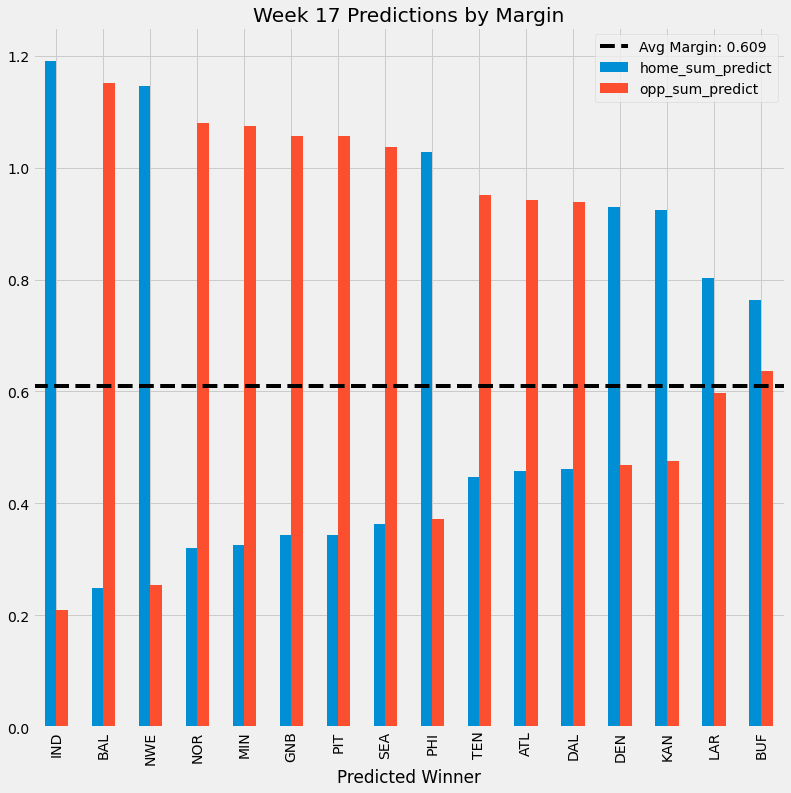

In [16]:
name_list = []
for i in range(len(future_df['datetime'])):
    if future_df['predicted_outcome'].iloc[i] == 0:
        name_list.append(future_df['team'].iloc[i])
    else:
        name_list.append(future_df['opp'].iloc[i])
    
future_df[['home_sum_predict', 'opp_sum_predict']].plot(kind='bar', figsize=(12, 12))
locs, labels=plt.xticks()
plt.xticks(locs, name_list)
plt.title(f'Week {upcoming_week} Predictions by Margin')
plt.xlabel('Predicted Winner')
plt.axhline(future_df['margin'].mean(), linestyle='--', color='black', label=f'Avg Margin: {round(future_df["margin"].mean(), 3)}')
plt.legend()
plt.savefig('current_predictions.png')


plt.show()


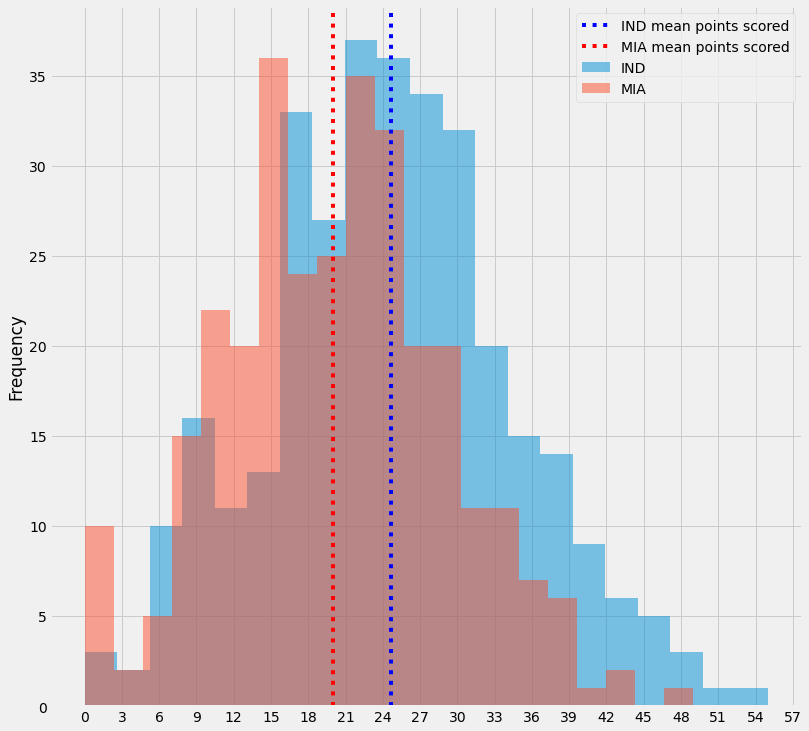

In [17]:
# these cells are just ways of accessing what the model is seeing for spot checks.
team1 = 'IND'
team2 = 'MIA'

team_data_dict_all[team1]['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label=team1)
team_data_dict_all[team2]['team_off'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label=team2)
plt.axvline(team_data_dict_all[team1]['team_off'].mean(), linestyle=":", color='b', label = f'{team1} mean points scored')
plt.axvline(team_data_dict_all[team2]['team_off'].mean(), linestyle=':', color = 'r', label = f'{team2} mean points scored')
plt.xticks(range(0, 60, 3))
plt.legend()
plt.show()

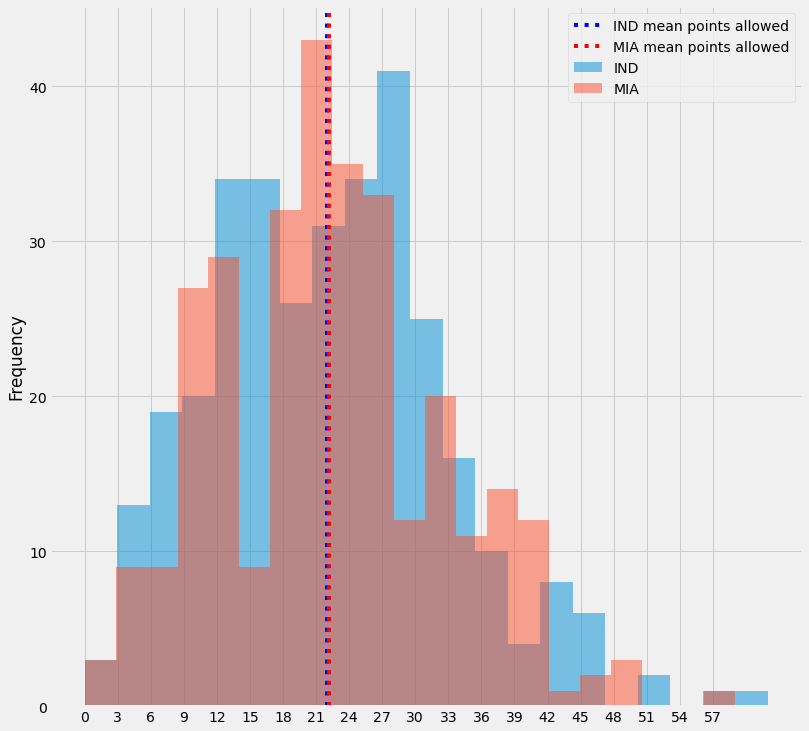

In [18]:
team_data_dict_all[team1]['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label = team1)
team_data_dict_all[team2]['team_def'].plot(kind='hist', figsize = (12,12), bins=21, alpha=0.5, label = team2)
plt.axvline(team_data_dict_all[team1]['team_def'].mean(), linestyle=":", color='b', label = f'{team1} mean points allowed')
plt.axvline(team_data_dict_all[team2]['team_def'].mean(), linestyle=':', color = 'r', label = f'{team2} mean points allowed')
plt.xticks(range(0, 60, 3))
plt.legend()
plt.show()